In [1]:
import pandas as pd
import numpy as np
import time
import os
import pickle
import random
import glob
import eviltransform

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.dates import DateFormatter
import matplotlib.dates as md

plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=12)

%matplotlib inline

def defaultPlotParams(ax):
    ax.grid(True, axis="both", alpha=0.5, clip_on=False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(0)

# Get the data

All data fetching/transformation scripts are included in [utilities.py](utilities.py) file. An example is shown below.

2018-12-10 17:16:33,798 utilities    INFO     File: ../data/Data-21.tar.gz
2018-12-10 17:16:33,799 utilities    INFO     Read data (282540 rows) in 58.771153 sec
2018-12-10 17:16:33,875 utilities    INFO     Unique trips: 7104, unique drivers: 5092


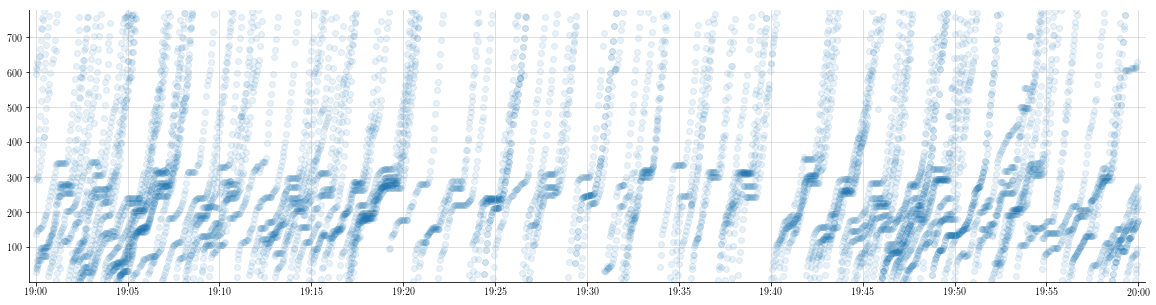

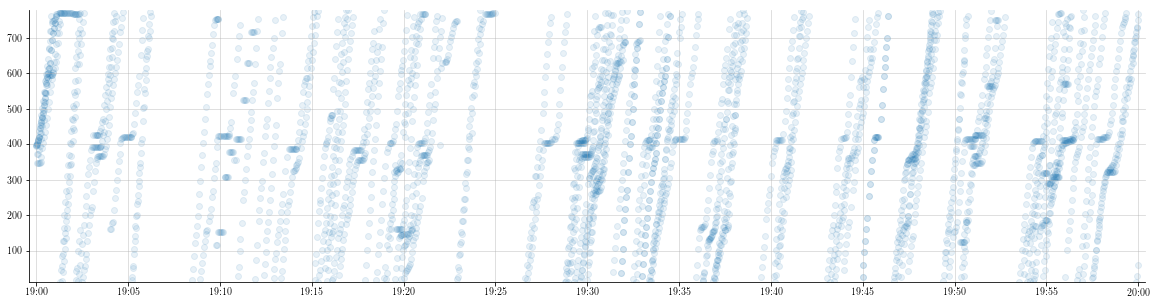

In [8]:
from utilities import fetch

# plot a random day
N_DAYS = 1
SOURCE_FOLDER = "../data"
AREAS = {
        'label': 'study-area',
        'threshold': 200,
        'bbox': [(34.241, 108.943), (34.241, 108.9415), (34.234, 108.9415), (34.234, 108.943)]
        }

# make the transforms to get the bounding box in GCJ
pts = [eviltransform.wgs2gcj(p, q) for (p, q) in AREAS['bbox']]
pts = pd.DataFrame(pts, columns=['lat', 'lon'])
bbox = (pts.lat.min(), pts.lat.max(), pts.lon.min(), pts.lon.max())

a = glob.glob(SOURCE_FOLDER + "/*.gz")
files = random.sample(a, N_DAYS)

def plot_data(df, h, d):
    figure1, ax = plt.subplots(1, 1, figsize=(20,5), sharey='row')

    ax.clear()
    defaultPlotParams(ax)

    c1 = df.timestamp.dt.hour == h
    c2 = df.direction == d

    idx = c1 & c2
    
    xlocator = md.MinuteLocator(byminute=list(range(0, 61, 5)), interval = 1)

    ax.scatter(list(df[idx].timestamp.values), df[idx].distance, alpha=0.1)
    
    myFmt = DateFormatter("%H:%M")
    ax.xaxis.set_major_formatter(myFmt)
    ax.xaxis.set_major_locator(xlocator)

    # ax.set_xlim([df[idx].timestamp.min(), df[idx].timestamp.max()])
    #plt.savefig("img/{}-{}-{}_dir-{}.hour-{}.png".format(df.timestamp.iat[0].year, df.timestamp.iat[0].month, df.timestamp.iat[0].day, d, h))
    #plt.close()
    plt.show()

for f in files:
    df = fetch(f, bbox, AREAS['threshold'])
    for d in ['north', 'south']:
        plot_data(df, 19, d)

            

We'll test the method on an internal test bed before making the final submission. So partition into `training` and `test`. 

In [4]:
# get the raw time series
fn = "consolidated.csv.zip"
data = pd.read_csv(fn, compression='zip', parse_dates=['timestamp'])

# Restrict to weekdays
data['weekday'] = data.timestamp.dt.weekday < 5
data = data[data['weekday']]

DIRECTIONS = ['north', 'south']

# Everything before this is training data
INTERNAL_TEST_PERIOD = pd.to_datetime("2016-11-27 00:00:00")

train_df = data[data.timestamp<INTERNAL_TEST_PERIOD]
test_df = data[data.timestamp>=INTERNAL_TEST_PERIOD].copy(deep=True)

In [5]:
def fetch_sequence(x, direction):
    """
    Generate sequences from training period
    We interpolate linearily to deal with missing values
    """
    
    # Standarize the time intervals
    ts = pd.date_range(start=x.timestamp.min().date(), 
                       periods=12 * 24, 
                       freq='5min')
    result = pd.DataFrame({'timestamp': ts})

    result = result.merge(x, on='timestamp', how='left')
    result = result.interpolate(limit_direction='both')
    return result[direction]

histories = {}
ground_truth = {}
for d in DIRECTIONS:
    histories[d] = np.array(train_df\
                          .groupby(train_df.timestamp.dt.date)\
                          .apply(fetch_sequence, (d)))
    ground_truth[d] = np.array(test_df\
                             .groupby(test_df.timestamp.dt.date)\
                             .apply(fetch_sequence, (d)))

In [6]:
# Testing set up (mimic the competition)
test_hours = [6, 7, 8, 9, 10, 16, 17, 18, 19, 20]

def test_sequences(x, direction):
    """
    For test sequences, nan values are left as is.
    """
    
    # get the time intervals
    ts = pd.date_range(start=x.timestamp.min().date(), 
                       periods=12 * 24, 
                       freq='5min')
    result = pd.DataFrame({'timestamp': ts})
    result = result.merge(x, on='timestamp', how='left')
    return result[direction]

test_suite = {}
test_df = test_df.copy(deep=True)

for d in DIRECTIONS:
    
    # Set the test periods to be nan
    idx = test_df.timestamp.dt.hour.isin(test_hours)
    test_df.loc[idx, d] = np.nan

    test_suite[d] = np.array(test_df\
                .groupby(test_df.timestamp.dt.date)\
                .apply(test_sequences, (d)))

# The model

We'll build a separate model for each direction, so the sequence histories, partial time series are persisted for each direction independently. 

In [7]:
def predict(v, history, bandwidth):
    """
    Implements the non-parameteric kernel regression function. 
    
    It first computes the kernel weight, and then generates the forecast
    based on the kernel.
    
    :param v: the partial data w.r.t. which kernel should be computed
        treats non np.nan values as available observations
        and np.nan values as the ones for which we need to predict
    :param history: the historical time series
    :param bandwidth: kernel bandwidth parameter
    """
    
    # First compute kernel
    n_samples, _ = history.shape
    kernel = np.zeros(n_samples)
    
    # Get the variance per time step
    variance = np.var(history, axis=0)
    variance[variance<1] = 1.0
    
    # Compute kernel
    mask = ~np.isnan(v)
    for i in np.arange(n_samples):
        kernel[i] = np.exp(-(1.0/ bandwidth) * np.sum((history[i, mask] - v[mask])**2/variance[mask]))
    
    # normalize
    kernel /= kernel.max()
    
    # Now make the prediction
    result = np.copy(v)
    mask = np.isnan(v)
    
    prediction = (np.mat(kernel) * history).A1/sum(kernel)
    
    result[mask] = prediction[mask]
    
    return result, kernel

# Evaluation

In [11]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# tuned bandwidth parameters
bandwidths = {'north': 50, 'south': 50}
#bandwidths = [0.1, 1.0, 10.0, 50.0, 90.0, 100.0, 120.0, 200.0]

predictions = {}
for d in DIRECTIONS:
    #for b in bandwidths:
    history = histories[d]
    tests = test_suite[d]
    truth = ground_truth[d]

    pred = []
    for t in tests:

        #kernel = compute_kernel(t, history, bandwidths[d]) # bandwidth=b)# 
        p, _ = predict(t, history, bandwidths[d])
        pred.append(p)

    predictions[d] = pred

    rmse = []
    for tr, pr in zip(truth, pred):
        rmse.append((sqrt(mean_squared_error(tr, pr))))
    print("Direction: {} RMSE: {}".format(d, np.mean(rmse[:-1])))
    #print("Bandwidth: {}, Direction: {} RMSE: {}".format(b, d, np.mean(rmse[:-1])))
    print(rmse[:-1])


Direction: north RMSE: 7.640664620975066
[7.640664620975066]


KeyError: 'south'

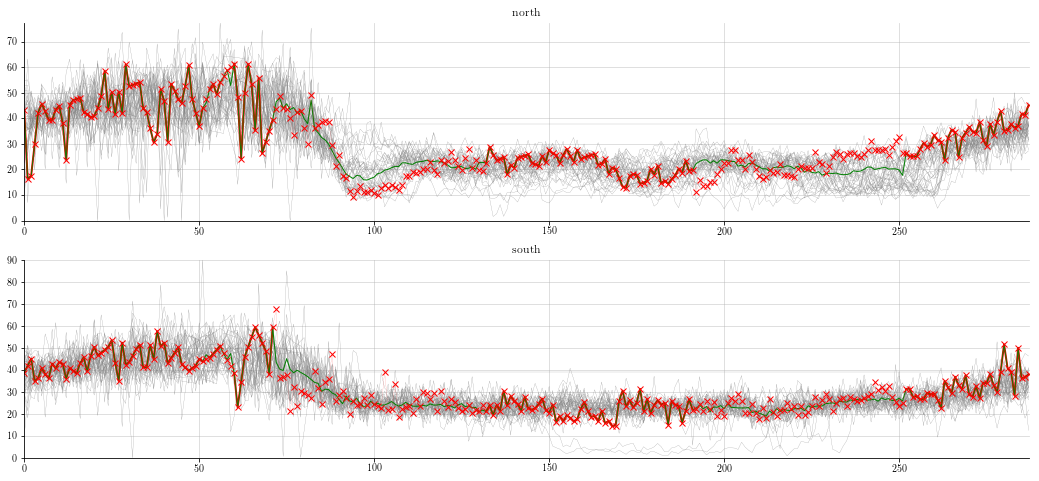

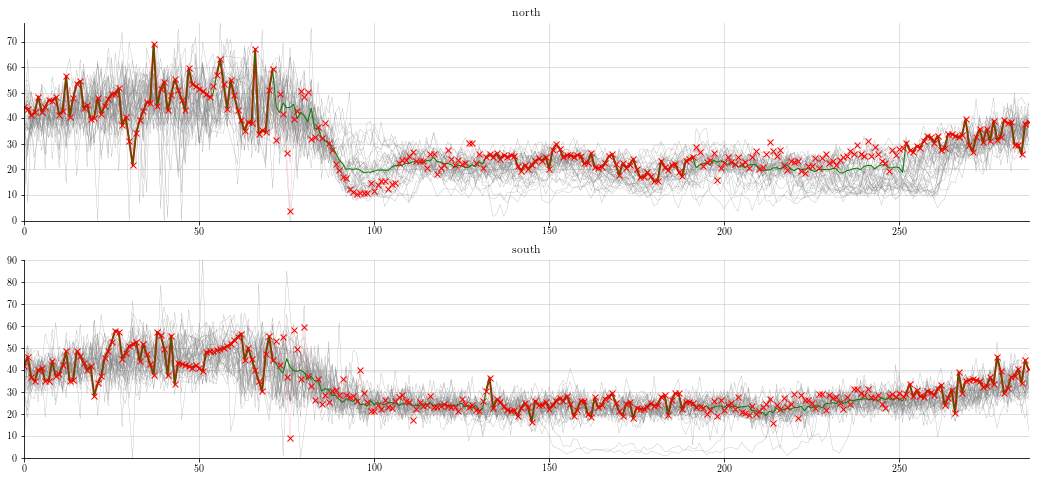

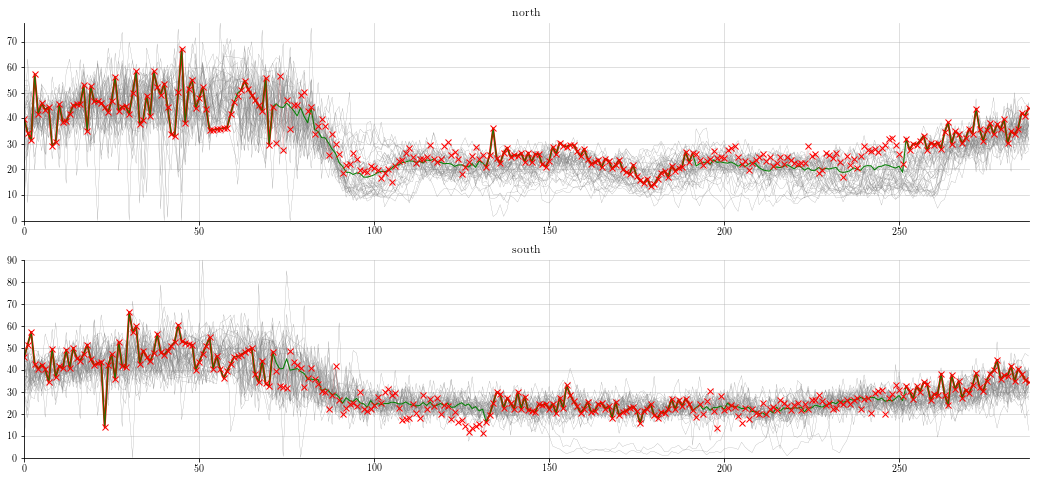

In [9]:

for testno in [0, 1, 2]:

    figure1, axarr = plt.subplots(2, 1, figsize=(18,8), sharex='row')

    for ax in axarr:
        ax.clear()
        defaultPlotParams(ax)

    for i, d in enumerate(DIRECTIONS):

        history = histories[d]
        tests = test_suite[d]
        truth = ground_truth[d]
        pred = predictions[d]

        for h in history:
            axarr[i].plot(h, color='grey', linewidth=0.2)

        
        axarr[i].plot(tests[testno], color='red', linewidth=2)
        axarr[i].plot(pred[testno], color='green', linewidth=1.0)
        axarr[i].plot(truth[testno, :], color='red', linewidth=0.1, marker='x')
        
        axarr[i].set_title(d)
    #plt.savefig("kernel/{}.png".format(testno))

# Prepare the submission

We will use the same setup as above, but use all the data for training. 

In [9]:
# get the raw time series (includes test periods)
fn = "consolidated.csv.zip"
data = pd.read_csv(fn, compression='zip', parse_dates=['timestamp'])

# Restrict to weekdays
data['weekday'] = data.timestamp.dt.weekday < 5
data = data[data['weekday']]

DIRECTIONS = ['north', 'south']

train_df = data.copy(deep=True)

fn = "consolidated.csv"
test_df = pd.read_csv(fn, parse_dates=['timestamp'])

# we have some missing values outside the test period, so handle these
test_df.interpolate(limit_direction='both', inplace=True)
# Set the test periods to be nan
idx = test_df.timestamp.dt.hour.isin(test_hours)
test_df.loc[idx, DIRECTIONS] = np.nan

In [12]:
histories = {}
test_suite = {}
predictions = {}
for d in DIRECTIONS:
    histories[d] = np.array(train_df\
                          .groupby(train_df.timestamp.dt.date)\
                          .apply(fetch_sequence, (d)))

    test_suite[d] = np.array(test_df\
                .groupby(test_df.timestamp.dt.date)\
                .apply(test_sequences, (d)))

    p, _ = predict(test_suite[d][0], histories[d], bandwidths[d])
    predictions[d] = p


# Plot the result

In [14]:
# get the "official" speed estimates for known periods
transfors = {}
offset = {'north': '5 seconds', 'south': '4 seconds'}
        
for d in DIRECTIONS:
    tm = pd.read_csv("Predictions/Predictions_{}.csv".format(d), na_values='x')
    tm['timestamp'] = pd.to_datetime("2016-12-01 " + tm.time)
    tm['timestamp'] -= pd.Timedelta(offset[d])
    # Since there are missing values, convert to standard time intervals
    # get the time intervals
    ts = pd.date_range(start=tm.timestamp.min().date(), 
                       periods=12 * 24, 
                       freq='5min')
    result = pd.DataFrame({'timestamp': ts})
    out = result.merge(tm, on='timestamp', how='left')
    transfors[d] = out
    

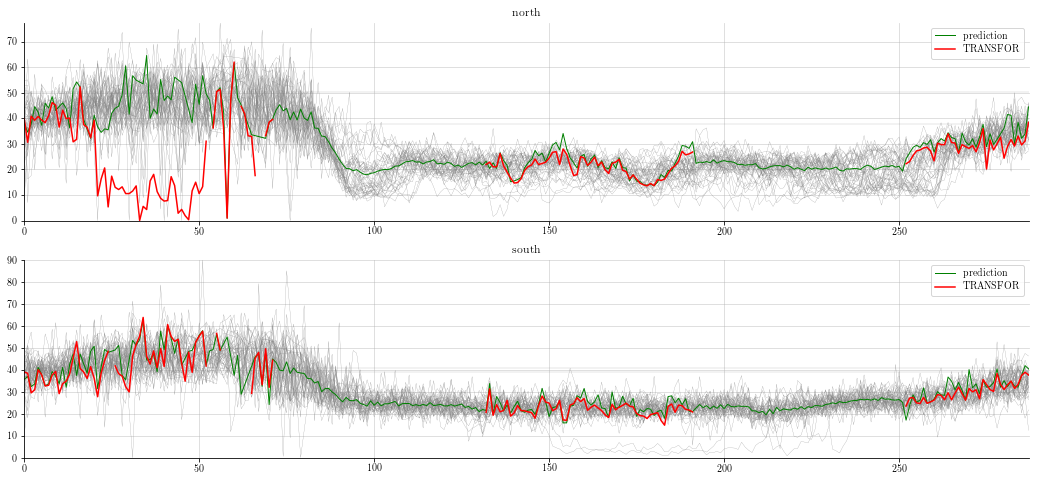

In [16]:
figure1, axarr = plt.subplots(2, 1, figsize=(18,8), sharex='row')

for ax in axarr:
    ax.clear()
    defaultPlotParams(ax)

for i, d in enumerate(DIRECTIONS):

    history = histories[d]
    test = test_suite[d][0]
    pred = predictions[d]

    for h in history:
        axarr[i].plot(h, color='grey', linewidth=0.2)

    # axarr[i].plot(test, color='dar', linewidth=2)
    axarr[i].plot(pred, color='green', linewidth=1.0, label='prediction')

    # also plot the partial TRANSFOR data
    axarr[i].plot(transfors[d].speed, label='TRANSFOR', color='r')
    axarr[i].set_title(d)
    axarr[i].legend(loc=0)
plt.savefig("bias.png")

Clear speed computation differences between ours and competition known results. Particularly in the early hours of the north bound traffic. Slight bias of speed values when the number of probes are high. Our predictions, which denoise the data rather aggressively tend to be higher. 

We make two submissions:
   - (a) As is.
   - (b) with a mean correction factor to account for differences in speed computation.

In [72]:
for d in DIRECTIONS:
    mask = ((transfors[d].timestamp>"2016-12-01 11:00:00") &
            (transfors[d].timestamp<"2016-12-01 22:00:00"))
    orig = transfors[d][mask].speed
    pred = predictions[d][mask]
    print("Average bias ({}): {}".format(d, np.mean(orig-pred)))

Average bias (north): -1.4481477201153632
Average bias (south): -1.2928651979397827


# Prepare the submission files

In [73]:

def make_submission_file(predictions, path_prefix):
    
    if not os.path.exists(path_prefix):
        os.mkdir(path_prefix)
    
    offset = {'north': '5 seconds', 'south': '4 seconds'}
    for d in DIRECTIONS:

        ts = pd.date_range(start="2016-12-01", 
                       periods=12 * 24, 
                       freq='5min')
        result = pd.DataFrame({'time': ts, 'speed': predictions[d]})
        result.time += pd.Timedelta(offset[d])

        result[['time', 'speed']].to_csv("{}/Predictions_{}.csv".format(path_prefix, d), 
                                         index=False,
                                         date_format="%H:%M:%S")

make_submission_file(predictions, "sub1")

In [74]:
prediction2 = {k: v for k, v in predictions.items()}
for d in DIRECTIONS:
    pred = prediction2[d]
    pred -= 1.29

In [79]:
make_submission_file(prediction2, 'sub2')